# Superstore Sales Data

Time series forecasting is the use of a model to predict future values based on previously observed values.
This method is widely used for non-stationary data, like economic, weather, stock price, and retail sales.

in this project we will be utlising a sample dataset named "Superstore Sales", which includes 4 years of daily Sales data by customer and category. The dataset containing information related to Sales, Profits and other interesting facts of a Superstore giant.

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
from prophet import Prophet
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'


There are several categories in the Superstore sales data, we start from time series analysis and forecasting for furniture sales.

In [2]:
df = pd.read_excel("desktop/data/Superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

There are 4-years furniture sales data.

In [4]:
furniture['Order Date'].min()

Timestamp('2014-01-06 00:00:00')

In [5]:
furniture['Order Date'].max()

Timestamp('2017-12-30 00:00:00')

# Data Preprocessing

Here we will be removing columns we do not need, check missing values, and aggregate sales by date.

In [6]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')


In [7]:
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [8]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [9]:
furniture.head()

,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940
3,2014-01-11,9.940
4,2014-01-13,879.939


# Indexing with Time Series Data

In [10]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

The current datetime data can be difficult to work with, therefore, we shall use the average daily sales value for the month instead. we will also use the start of each month as the timestamp.

In [11]:
y = furniture['Sales'].resample('MS').mean()

Sales data for 2017

In [12]:
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

# Visualising Furniture Sales Time Series Data

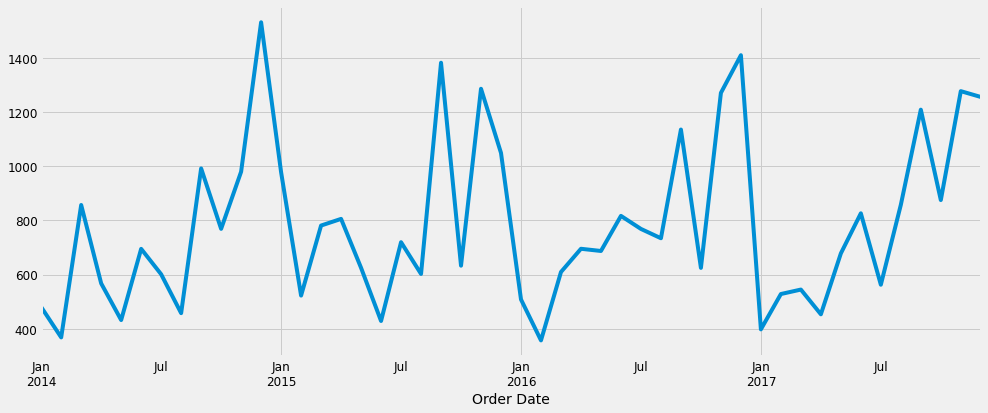

In [13]:
y.plot(figsize=(15, 6))
plt.show()

The time-series has seasonality patterns, such as sales are always low at the beginning of the year and high at the end of the year. Also, there is an upward trend within any single year with a couple of low months in the mid of the year.
We can avisualise the data using a method called time-series decomposition. This will strategy can be used to decompose our time series into three distinct components: trend, seasonality, and noise.

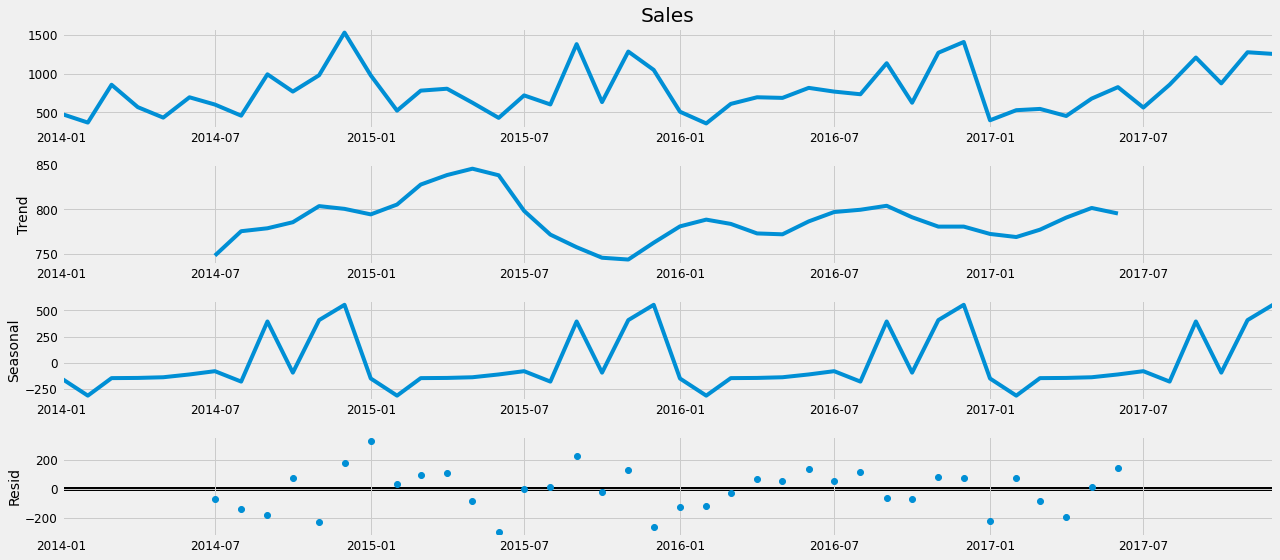

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

The above plot clearly demonstrates the sales of furniture is unstable, along with its obvious seasonality.

# Time Series Forecasting with ARIMA

ARIMA stands for Autoregressive Integrated Moving Average. This is a commonly used method for time-series forecasting.
ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data.

In [15]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


This step is parameter selection for our furniture’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yield the best performance for our model.

In [16]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.99048D+00    |proj g|=  1.66962D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      3      1     0     0   2.398D-07   7.990D+00
  F =   7.9904349200061615     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205915


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/syreetacharles-cole/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.99557D+01    |proj g|=  1.28244D-03
  ys=-2.953E+01  -gs= 6.856E-01 BFGS update SKIPPED
  ys=-7.221E+01  -gs= 7.219E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5     81      4     2     0   3.316D+04   1.629D+01
  F =   16.286197254340848     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1567.4749364167214
RUNNING THE L-BFGS-B CODE

       

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.62082D+00    |proj g|=  2.76207D-01

At iterate    5    f=  7.57452D+00    |proj g|=  1.26844D-03

At iterate   10    f=  7.57422D+00    |proj g|=  2.93923D-02

At iterate   15    f=  7.55111D+00    |proj g|=  2.39326D-01

At iterate   20    f=  7.46798D+00    |proj g|=  2.90340D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     23     27      1     0     0   4.725D-08   7.468D+00
  F =   7.4679711153730350     

CONVERG

 This problem is unconstrained.
/Users/syreetacharles-cole/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:291.6261389673288
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.77847D+00    |proj g|=  3.74770D-02

At iterate    5    f=  5.77414D+00    |proj g|=  8.20004D-04

At iterate   10    f=  5.77045D+00    |proj g|=  3.10556D-02

At iterate   15    f=  5.42367D+00    |proj g|=  2.22854D+00

At iterate   20    f=  5.23797D+00    |proj g|=  5.22733D-01

At iterate   25    f=  5.18502D+00    |proj g|=  1.92821D-01

At iterate   30    f=  5.16011D+00    |proj g|=  5.53690D-02

At iterate   35    f=  5.15002D+00    |proj g|=  9.09700D-03

At iterate   40    f=  5.14615D+00    |proj g|=  1.06010D-01

At iterate   45    f=  5.14303D+00    |proj g|=  1.50672D-02

At iterate   50    f=  5.14150D+00    |proj g|=  1.61332D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluatio

/Users/syreetacharles-cole/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  5.45145D+00    |proj g|=  8.79248D-04

At iterate   10    f=  5.45109D+00    |proj g|=  6.44613D-03

At iterate   15    f=  5.41623D+00    |proj g|=  1.60346D-01

At iterate   20    f=  4.96371D+00    |proj g|=  8.16892D-02

At iterate   25    f=  4.85418D+00    |proj g|=  4.27984D-01

At iterate   30    f=  4.81939D+00    |proj g|=  1.19212D-01

At iterate   35    f=  4.80172D+00    |proj g|=  7.28331D-02

At iterate   40    f=  4.79286D+00    |proj g|=  2.48191D-02

At iterate   45    f=  4.78849D+00    |proj g|=  3.87597D-02

At iterate   50    f=  4.78721D+00    |proj g|=  2.84633D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/syreetacharles-cole/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.30121D+00    |proj g|=  1.24497D-03

At iterate   10    f=  3.29918D+00    |proj g|=  3.27117D-02

At iterate   15    f=  3.27151D+00    |proj g|=  2.08397D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     22      1     0     0   1.068D-06   3.271D+00
  F =   3.2707134134863218     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.9884876946869
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/syreetacharles-cole/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:486.63785672393664
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.18743D+00    |proj g|=  1.32769D-01

At iterate    5    f=  3.16516D+00    |proj g|=  2.09181D-03

At iterate   10    f=  3.16263D+00    |proj g|=  3.87589D-02

At iterate   15    f=  3.13511D+00    |proj g|=  4.53866D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     18     20      1     0     0   3.612D-07   3.135D+00
  F =   3.1350741960082895     

CONVERGENCE: 

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/syreetacharles-cole/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6     96      2     3     0   1.297D+05   1.443D+01
  F =   14.432032688339477     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1391.4751380805899
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28929D+00    |proj g|=  4.82157D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explor

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/syreetacharles-cole/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.73495D+01    |proj g|=  8.51392D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10    127      4     0     0   1.279D+06   1.484D+01
  F =   14.844067480914935     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1431.0304781678337
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.76190D+00    |proj g|=  1.01285D-01

At iterate    5    f=  4.74718D+00    |proj g|=  5.28400D-04

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.
/Users/syreetacharles-cole/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


  ys=-5.850E+04  -gs= 6.738E+03 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      3     46      3     2     0   7.786D+05   2.015D+01
  F =   20.150051642394722     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:1942.4049576698933
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23022D+00    |proj g|=  3.65785D-02

At iterate    5    f=  3.22401D+00    |proj g|=  7.08917D-02

At iterate   10    f=  

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.96605D+01    |proj g|=  1.92146D-03

At iterate    5    f=  1.73586D+01    |proj g|=  3.38981D+04
  ys=-4.192E+01  -gs= 7.167E-01 BFGS update SKIPPED
  ys=-1.032E+00  -gs= 6.511E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     90      2     2     0   8.762D+04   1.591D+01
  F =   15.908206646592108     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1533.1878380728424
RUNNING THE L-BFG


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/syreetacharles-cole/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:304.207767516094
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.19919D+00    |proj g|=  2.41292D-01

At iterate    5    f=  5.09833D+00    |proj g|=  1.23092D-02

At iterate   10    f=  5.09817D+00    |proj g|=  1.03693D-02

At iterate   15    f=  5.07999D+00    |proj g|=  1.97990D-01

At iterate   20    f=  4.94876D+00    |proj g|=  1.37182D-01

At iterate   25    f=  4.94715D+00    |proj g|=  1.23881D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Pr

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.14546D+00    |proj g|=  3.59067D-03

At iterate   10    f=  3.13253D+00    |proj g|=  7.92845D-02

At iterate   15    f=  3.10903D+00    |proj g|=  5.29960D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     22      1     0     0   1.329D-06   3.109D+00
  F =   3.1090257032131081     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:304.4664675084584
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/syreetacharles-cole/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   10    f=  4.81634D+00    |proj g|=  1.74888D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     27      1     0     0   5.353D-05   4.816D+00
  F =   4.8163387456407021     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:468.3685195815074
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.03742D+00    |proj g|=  1.63757D-01

At iterate    5    f=  3.01183D+00    |proj g|=  2.30374D-03

At iterate   1

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  4.94416D+00    |proj g|=  2.94019D-02

At iterate   30    f=  4.94350D+00    |proj g|=  2.63627D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     41      1     0     0   1.483D-05   4.944D+00
  F =   4.9435034623719920     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:482.57633238771126
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.95306D+00    |proj g|=  2.12918D-01

At iterate   

 This problem is unconstrained.
/Users/syreetacharles-cole/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  4.77281D+00    |proj g|=  2.78192D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     69      1     0     0   2.782D-05   4.773D+00
  F =   4.7728082424366187     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:468.1895912739154
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15364D+00    |proj g|=  6.09532D-02

At iterate    5    f=  3.14852D+00    |proj g|=  6.15364D-03

At iterate   1

 This problem is unconstrained.



At iterate    5    f=  3.01342D+00    |proj g|=  2.60897D-02

At iterate   10    f=  3.01179D+00    |proj g|=  1.00053D-03

At iterate   15    f=  3.01166D+00    |proj g|=  7.46525D-03

At iterate   20    f=  3.01000D+00    |proj g|=  1.42643D-02

At iterate   25    f=  2.99312D+00    |proj g|=  7.16705D-02

At iterate   30    f=  2.97362D+00    |proj g|=  9.14851D-02

At iterate   35    f=  2.95838D+00    |proj g|=  1.12162D-01

At iterate   40    f=  2.95575D+00    |proj g|=  6.31199D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43     56      1     0     0   9.664D-06   2.956D+00
  F =   2.95574290428

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     24      1     0     0   2.558D-07   3.065D+00
  F =   3.0647193871032279     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:300.2130611619099
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.95997D+00    |proj g|=  3.34294D-02

At iterate    5    f=  4.95798D+00    |proj g|=  2.40641D-02

At iterate   10    f=  4.90324D+00    |proj g|=  1.99570D-01

At iterate   1

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/syreetacharles-cole/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7     84      2     1     0   3.249D+02   1.534D+01
  F =   15.341953676077779     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1480.8275529034668
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.10197D+00    |proj g|=  1.68835D-02

At iterate    5    f=  3.10136D+00    |proj g|=  1.04559D-02

At iterate   10    f=  3.08543D+00    |proj g|=  1.26872D-01

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  4.74738D+00    |proj g|=  7.45904D-02

At iterate   10    f=  4.74215D+00    |proj g|=  5.05521D-04

At iterate   15    f=  4.74189D+00    |proj g|=  1.89004D-02

At iterate   20    f=  4.73466D+00    |proj g|=  2.88447D-02

At iterate   25    f=  4.73413D+00    |proj g|=  7.19167D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     33      1     0     0   7.192D-06   4.734D+00
  F =   4.7341277995940780     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:460.4762687610315
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  2.87973D+00    |proj g|=  3.06134D-02

At iterate   25    f=  2.84939D+00    |proj g|=  4.57846D-02

At iterate   30    f=  2.84778D+00    |proj g|=  1.98131D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     42      1     1     0   2.279D-06   2.848D+00
  F =   2.8477843822285216     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:281.3873006939381
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/syreetacharles-cole/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      5     68      2     0     0   1.674D+05   2.226D+01
  F =   22.263050059120150     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:2147.2528056755345
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09103D+00    |proj g|=  3.72719D-02

At iterate    5    f=  3.08056D+00    |proj g|=  3.47745D-02

At iterate   10    f=  3.07783D+00    |proj g|=  1.16849D-03
  ys=-2.589E-0

 This problem is unconstrained.



At iterate   30    f=  3.01863D+00    |proj g|=  1.40200D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     58      1     1     0   9.460D-05   3.019D+00
  F =   3.0186202495180727     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:297.787543953735
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.98342D+00    |proj g|=  1.76988D-01

At iterate    5    f=  2.94075D+00    |proj g|=  1.72204D-01

At iterate   10

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     48      1     0     0   4.795D-05   2.848D+00
  F =   2.8475635566831436     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:283.3661014415818


# Fitting the ARIMA Model


In [17]:
mod = sm.tsa.statespace.SARIMAX(y, order=(1, 1, 1),
                            seasonal_order=(1, 1, 0, 12),
                            enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.04808D+00    |proj g|=  8.88357D-02

At iterate    5    f=  5.01487D+00    |proj g|=  2.85906D-02

At iterate   10    f=  5.01305D+00    |proj g|=  8.83301D-04

At iterate   15    f=  5.01275D+00    |proj g|=  1.18778D-02

At iterate   20    f=  4.99531D+00    |proj g|=  9.50057D-02

At iterate   25    f=  4.98503D+00    |proj g|=  1.23488D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     37      1     0     0   

 This problem is unconstrained.


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0676      0.226      0.299      0.765      -0.376       0.511
ma.L1         -1.0000      0.279     -3.590      0.000      -1.546      -0.454
ar.S.L12      -0.4807      0.147     -3.260      0.001      -0.770      -0.192
sigma2      4.108e+04   6.78e-06   6.06e+09      0.000    4.11e+04    4.11e+04



We will run the model diagnostics to investigate unusual behaviour.

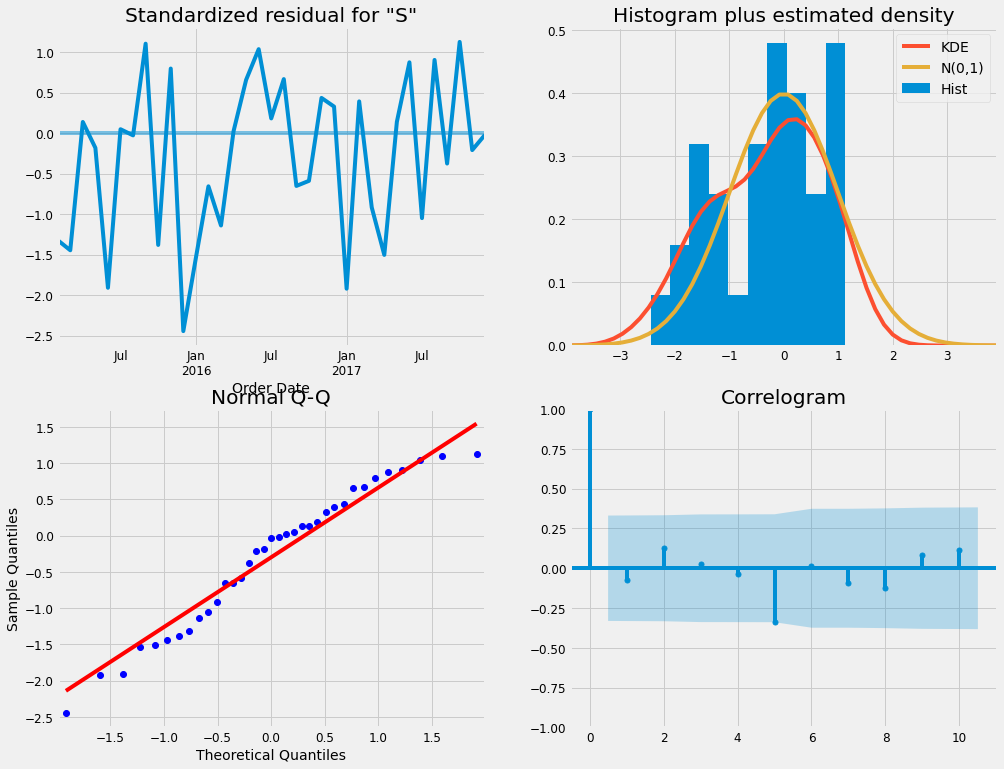

In [18]:
results.plot_diagnostics(figsize=(15, 12)) 
plt.show()

# Validating Forecasts

We compare predicted sales to real sales of the time series, and we set forecasts to start at 2017-07-01 to the end of the data.

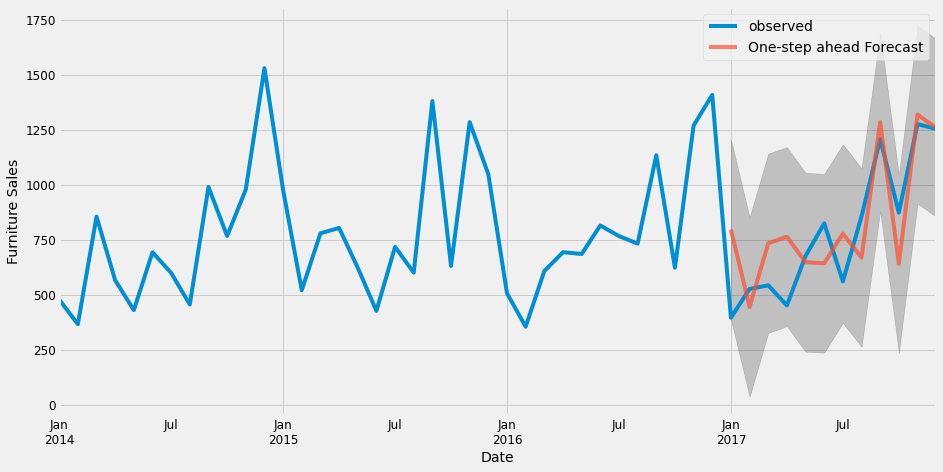

In [19]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts aligned with the true values demonstrating an upward trend starts from the beginning of the year.

In [20]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 39996.01


In [21]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 199.99


In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator—it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily furniture sales in the test set within 151.64 of the real sales. Our furniture daily sales range from around 400 to over 1200. In my opinion, this is a pretty good model so far.

# Producing and Visualising Forecasts

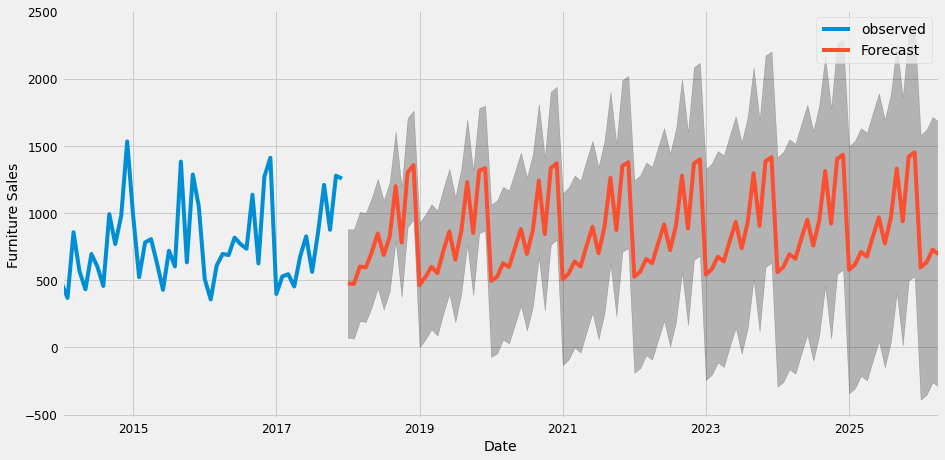

In [22]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')

plt.legend()
plt.show()

Our model clearly captured furniture sales seasonality. As we forecast further out into the future, there may be  less confidence in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

The above time series analysis for furniture warrants an observation of other categories, and how do they compare with each other overtime time. Therefore, we are going to compare time series of furniture and office supplier.

# Time Series Comparison Furniture Sales and Office Supplies

# Data Preprocessing

In [23]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']

According to our data, there were way more number of sales from Office Supplies than from Furniture over the years.

In [24]:
furniture.shape, office.shape

((2121, 21), (6026, 21))

In [25]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)

furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')

furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()

 Have a quick peek, perfect!

In [26]:
furniture.head()

,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940
3,2014-01-11,9.940
4,2014-01-13,879.939


In [27]:
office.head()

,Order Date,Sales
0,2014-01-03,16.448
1,2014-01-04,288.060
2,2014-01-05,19.536
3,2014-01-06,685.340
4,2014-01-07,10.430


# Data Exploration

Next we will compare two categories sales in the same time period. This means combine two data frames into one and plot these two categories' time series into one plot.

In [28]:
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')

y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()

furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})

store = furniture.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


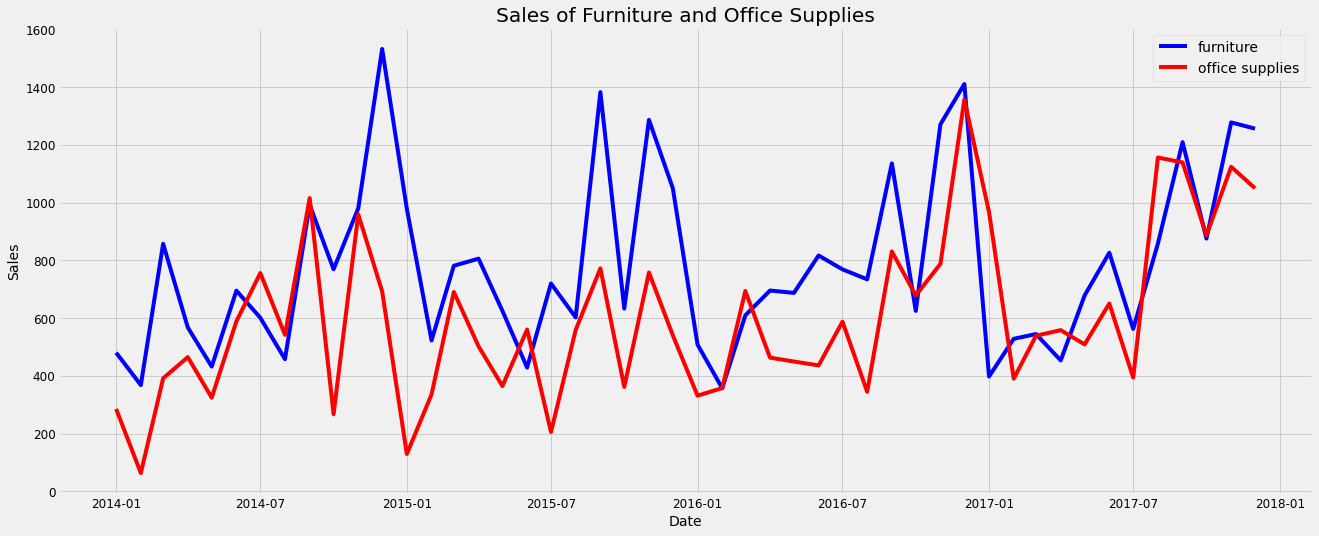

In [29]:
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'office supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Furniture and Office Supplies')
plt.legend();

We observe that sales of furniture and office supplies shared a similar seasonal pattern. Early of the year is the off season for both of the two categories. It seems summer time is quiet for office supplies too. in addition, average daily sales for furniture are higher than those of office supplies in most of the months. It is understandable, as the value of furniture should be much higher than those of office supplies. Occationaly, office supplies passed furnitue on average daily sales. Let's find out when was the first time office supplies' sales surpassed those of furniture's.

In [30]:
first_date = store.loc[np.min(list(np.where(store['office_sales'] > store['furniture_sales'])[0])), 'Order Date']

print("Office supplies first time produced higher sales than furniture is {}.".format(first_date.date()))

Office supplies first time produced higher sales than furniture is 2014-07-01.


It was July 2014.

# Time Series Modelling with Prophet

In [31]:
from prophet import Prophet

furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)

office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -59.4782
Iteration  1. Log joint probability =    32.1963. Improved by 91.6745.
Iteration  2. Log joint probability =    66.4876. Improved by 34.2913.
Iteration  3. Log joint probability =    91.4725. Improved by 24.9849.
Iteration  4. Log joint probability =    97.1278. Improved by 5.65524.
Iteration  5. Log joint probability =     97.227. Improved by 0.099276.
Iteration  6. Log joint probability =    97.2722. Improved by 0.0451306.
Iteration  7. Log joint probability =    97.2786. Improved by 0.0064387.
Iteration  8. Log joint probability =    97.2875. Improved by 0.00892092.
Iteration  9. Log joint probability =    97.2913. Improved by 0.0037551.
Iteration 10. Log joint probability =    97.2951. Improved by 0.00385468.
Iteration 11. Log joint probability =    97.2963. Improved by 0.00112628.
Iteration 12. Log joint probability =    97.2966. Improved by 0.000305425.
Iteration 13. Log joint probability =    97.2991. Improved by 0.00250368.
Iteration 14

by 0.00378284.
Iteration 15. Log joint probability =    80.0739. Improved by 0.00902414.
Iteration 16. Log joint probability =    80.0752. Improved by 0.00127615.
Iteration 17. Log joint probability =    80.0765. Improved by 0.00131062.
Iteration 18. Log joint probability =    80.0794. Improved by 0.00291987.
Iteration 19. Log joint probability =    80.0809. Improved by 0.0014927.
Iteration 20. Log joint probability =    80.0823. Improved by 0.00137598.
Iteration 21. Log joint probability =    80.0831. Improved by 0.000815686.
Iteration 22. Log joint probability =    80.0848. Improved by 0.00167409.
Iteration 23. Log joint probability =    80.0854. Improved by 0.00061637.
Iteration 24. Log joint probability =    80.0863. Improved by 0.000947166.
Iteration 25. Log joint probability =    80.0868. Improved by 0.000487622.
Iteration 26. Log joint probability =    80.0872. Improved by 0.000330843.
Iteration 27. Log joint probability =    80.0874. Improved by 0.000227349.
Iteration 28. Log j

Prophet (forecasting tool) is designed for analysing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore, we are using Prophet to get a model up and running.



In [32]:
furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)

office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)

<Figure size 1296x432 with 0 Axes>

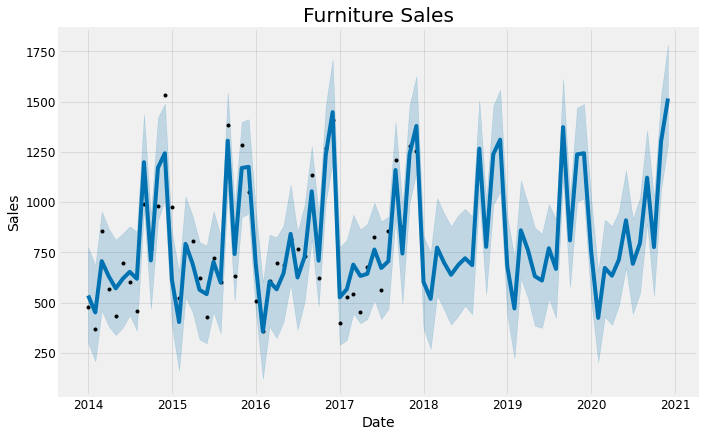

In [33]:
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales');

<Figure size 1296x432 with 0 Axes>

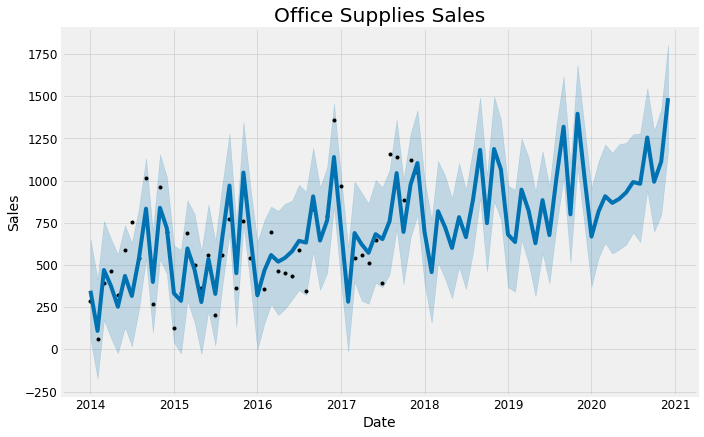

In [34]:
plt.figure(figsize=(18, 6))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales');

# Compare Forecasts
We already have the forecasts for three years for these two categories into the future. We will now join them together to compare their future forecasts.

In [36]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]

merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()

merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names

forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'office_ds')

forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()

,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,...,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2014-01-01,726.057713,298.817332,775.390364,726.057713,726.057713,-190.685662,-190.685662,-190.685662,-190.685662,...,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,0.0,0.0,0.0,347.490278
1,2014-02-01,727.494023,208.634041,684.602349,727.494023,727.494023,-276.377703,-276.377703,-276.377703,-276.377703,...,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,0.0,0.0,0.0,109.240162
2,2014-03-01,728.791335,461.885857,953.790414,728.791335,728.791335,-22.389755,-22.389755,-22.389755,-22.389755,...,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,0.0,0.0,0.0,470.211349
3,2014-04-01,730.227645,381.108043,867.006092,730.227645,730.227645,-100.141158,-100.141158,-100.141158,-100.141158,...,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,0.0,0.0,0.0,374.687188
4,2014-05-01,731.617622,338.670262,812.017213,731.617622,731.617622,-160.815662,-160.815662,-160.815662,-160.815662,...,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,0.0,0.0,0.0,252.306682


# Visualising the Trend and the Forecast

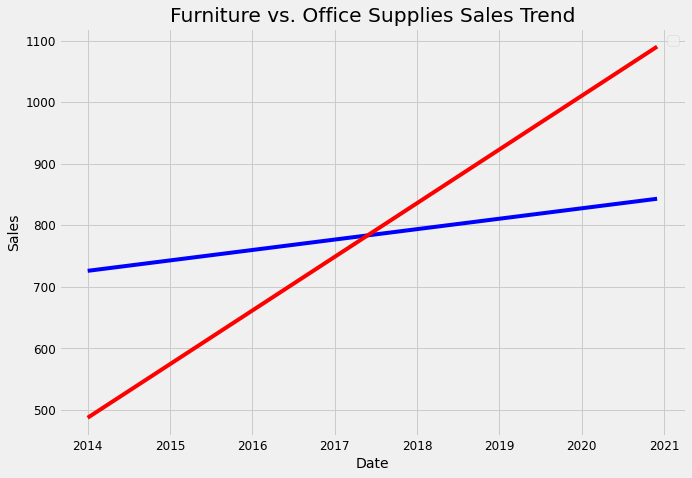

In [37]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-')
plt.plot(forecast['Date'], forecast['office_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Sales Trend');

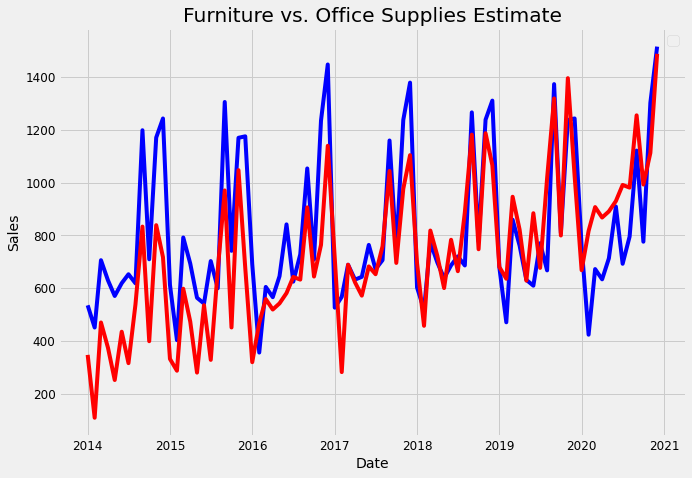

In [38]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimate');

# Trends and Patterns
Now, we can use the Prophet Models to inspect different trends of these two categories in the data.

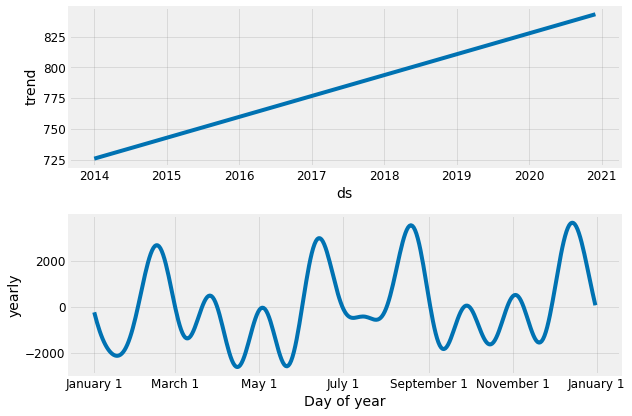

In [39]:
furniture_model.plot_components(furniture_forecast);

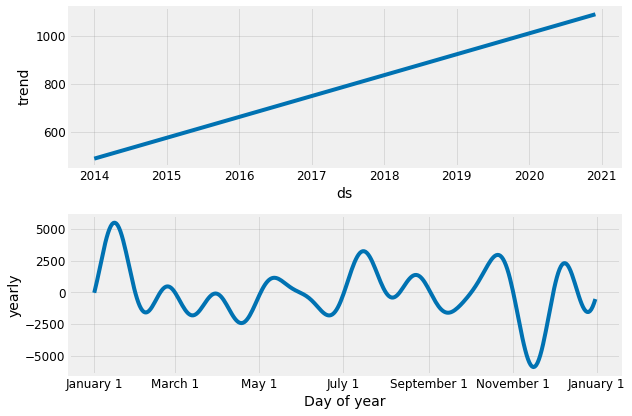

In [40]:
office_model.plot_components(office_forecast);

The sales for both furniture and office supplies have been increasing over time although office supplies growth seems slightly stronger.

The worst month for furniture is April, the worst month for office supplies is February. The best month for furniture is December, and the best month for office supplies is November.

Next Steps

There are many time-series analysis we can explore from here, such as forecast with uncertainty bounds, change point and anomaly detection, forecast time-series with external data source. 